In [81]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
import mne
import pandas as pd
import numpy as np

def read_csv(eeg_csv, channels, sfreq = 256, montage = 'standard_1020', useless_cols = ['timestamp', 'sequence', 'battery', 'flags']):
  df = pd.read_csv(eeg_csv)
  df_mne = df.drop(useless_cols, axis=1)

  # Transpose the matrix because MNE expects it like that
  data_mne = df_mne.to_numpy().transpose()

  # Scale the data
  # data_mne = data_mne / 1000000

  # Create MNE Raw's Info object
  info_mne = mne.create_info(
      #ch_names=list(df_mne.columns),
      ch_names=channels,
      ch_types='eeg',
      sfreq=sfreq)

  bbt_raw = mne.io.RawArray(data_mne, info_mne)
  ten_twenty_montage = mne.channels.make_standard_montage(montage)

  raw = bbt_raw.copy().set_montage(ten_twenty_montage)
  return raw

In [83]:
import numpy as np

def filters(raw, fmin = 0.5, fmax = 100., notch = 50., sampling_rate = 250, fir_design = 'firwin'):

    '''Apply high/low-pass and notch filters:

        === Args ===
        * raw - mne Raw object: object to apply filters on
        * fmin, fmax - float: bandpass frequencies
        * notch - float: powerline (AC current) frequecy
        * ny_freq - float: Nyquist frequency. Half of the sampling rate
        * fir_design: str: Notch filter type. See mne doc for more details
        * sampling_rate - int, float: sampling rate of the measured data

        === Returns ===
        * raw_c - mne Raw object: Processed Raw copy
        '''
    raw_c = raw.copy()
    raw_c.filter(l_freq = fmin, h_freq = fmax)
    raw_c.notch_filter(np.arange(notch, sampling_rate/2, notch), fir_design=fir_design)
    return raw_c

from math import floor

def windowfy_dataset(dataframe, chunk_size=100, n_channels=16):
    n_chunks = floor(dataframe.shape[0] / chunk_size)

    windows = np.ndarray(shape=(n_chunks, chunk_size, n_channels), dtype=float)

    channels_array = []
    for i in range(1, n_channels + 1):
        channels_array.append("EEG-ch" + str(i))

    dataframe_as_pd = dataframe[channels_array].to_numpy()
    # shape --> (samplesChannel, nChannels)

    for iChunk in range(n_chunks):
        for iSample in range(chunk_size):
            idf = (iChunk * chunk_size) + iSample
            windows[iChunk][iSample] = dataframe_as_pd[idf]

    return windows

In [84]:
def signal_df_to_np(dataframe, chunk_size=100, n_channels=16):
    n_chunks = floor(dataframe.shape[0] / chunk_size)

    windows = np.ndarray(shape=(n_channels, n_chunks, chunk_size), dtype=float)

    channels_array = []
    for i in range(1, n_channels + 1):
        channels_array.append("EEG-ch" + str(i))

    channels_as_pd = dataframe[channels_array].to_numpy()
    # shape --> (samplesChannel, nChannels)

    for iChannel in range(n_channels):
        for iChunk in range(n_chunks):
            for iSample in range(chunk_size):
                idf = (iChunk * chunk_size) + iSample
                windows[iChannel][iChunk][iSample] = channels_as_pd[idf][iChannel]

    # shape --> (channels, windows, samples)
    return windows


def channels_to_list_df(channels_data, artifact_label):
    # shape --> (channels, windows, samples)

    channels_list_df = []

    for channelData in channels_data:
        channel_data_map = {'label': []}

        for iWindow, window in enumerate(channelData):
            even = (iWindow % 2) == 0
            label = artifact_label if (even and iWindow != 0) else "pause"
            channel_data_map['label'].append(label)

            for iSample, sample in enumerate(window):
                if iSample in channel_data_map:
                    channel_data_map[iSample].append(sample)
                else:
                    channel_data_map[iSample] = [sample]

        channel_data_df = pd.DataFrame(channel_data_map)
        channels_list_df.append(channel_data_df)
        # df.columns = ['window', 'label']

    # array --> df(window, sample) + last column label
    return channels_list_df

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Data

In [86]:
import pandas as pd

eeg_file = "EEG.txt"

df = pd.read_csv(eeg_file)
df.head()

,timestamp,sequence,battery,flags,EEG-ch1,EEG-ch2,EEG-ch3,EEG-ch4,EEG-ch5,EEG-ch6,EEG-ch7,EEG-ch8,EEG-ch9,EEG-ch10,EEG-ch11,EEG-ch12,EEG-ch13,EEG-ch14,EEG-ch15,EEG-ch16
0,153804687683,16336,-2,0,-2553.890054,-6876.865884,31106.838605,214.528663,22527.894451,8132.718209,21134.279463,30553.415250,-10230.794172,-5388.805234,17134.538498,10109.798595,-17322.626756,17221.805220,-10619.150551,9531.200275
1,153804687683,16336,-2,0,-2557.710711,-6880.297175,31105.195966,214.772017,22528.880034,8132.827718,21137.443064,30554.473840,-10229.407054,-5388.087339,17137.081547,10109.774259,-17321.945365,17222.158083,-10620.878364,9531.504468
2,153804687683,16336,-2,0,-2570.961333,-6885.176421,31096.520398,210.002279,22524.438825,8130.528023,21134.948686,30551.626599,-10230.392638,-5389.218935,17135.268560,10101.329878,-17325.364488,17223.642542,-10621.778774,9531.832996
3,153804687683,16336,-2,0,-2585.039358,-6887.330103,31091.774996,201.935096,22518.805181,8127.899801,21129.205533,30548.767190,-10233.677916,-5390.934580,17132.956698,10096.827830,-17330.377579,17223.715548,-10622.642680,9530.056512
4,153804687683,16336,-2,0,-2573.200189,-6886.064663,31095.473976,200.523644,22517.126039,8126.330168,21127.404714,30550.957375,-10236.634666,-5391.761984,17130.401481,10101.926095,-17333.188317,17223.350517,-10622.022128,9527.744649


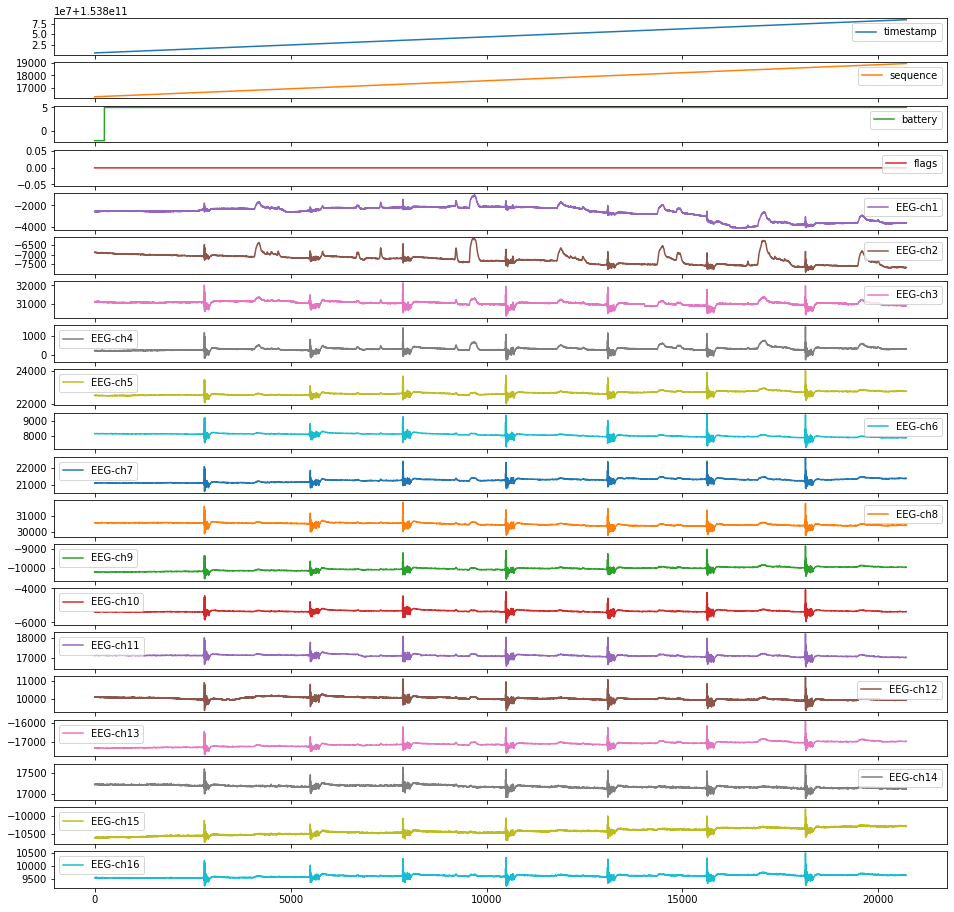

In [87]:
df.plot(subplots=True, figsize=(16, 16));

### Loading Data with BBT to operate on Frequency

In [88]:
raw_rubert = read_csv(eeg_file,
                        ['Fp1', 'Fp2', 'F3', 'F4', 'C1', 'C3', 'C2', 'C4', 'CP1', 'CP3', 'CP2', 'CP4', 'Cz', 'O1', 'O2', 'Pz'])

Creating RawArray with float64 data, n_channels=16, n_times=20712
    Range : 0 ... 20711 =      0.000 ...    80.902 secs
Ready.


Effective window size : 8.000 (s)


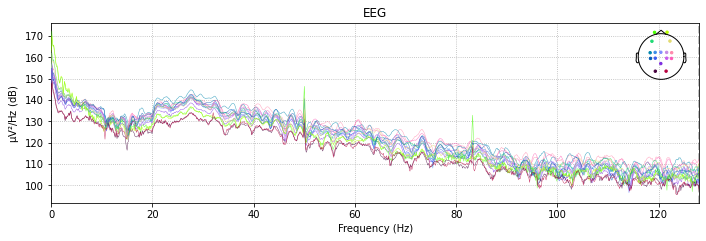

In [89]:
plot_raw = raw_rubert.plot_psd(fmin = 0, fmax = 128, average=False, tmin = 0, tmax = 120)
#plot_raw = raw_rubert.plot_psd(fmin = 0, fmax = 128, average=True, tmin = 0, tmax = 120)
#plot_raw = raw_rubert.plot_psd()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 sec)

Effective window size : 8.000 (s)


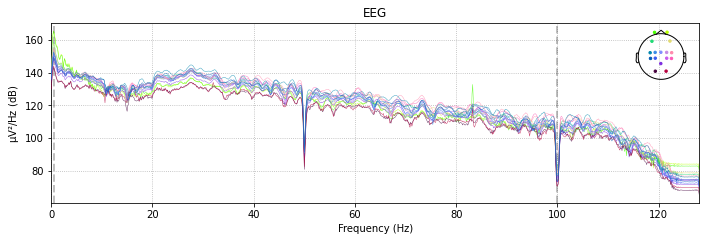

In [90]:
filtered_rubert = filters(raw_rubert)
plot_filtered = filtered_rubert.plot_psd(fmin = 0, fmax = 128, average=False, tmin = 0, tmax = 120)

In [91]:
save_path = '/content/pickle'

df.to_pickle(save_path + 'rubert_jaw_1.pkl')

### Slicing into smaller temporal windows

In [92]:
sampling_rate = 256
window_time = 5 # segs
window_size = window_time * sampling_rate
n_channels = 16

windows = signal_df_to_np(df, window_size, n_channels)

print("---SHAPE---")
print(windows.shape)
print("---DATA---")
print(windows[0])

---SHAPE---
(16, 16, 1280)
---DATA---
[[-2553.89005386 -2557.71071067 -2570.96133251 ... -2558.12441236
  -2568.63730241 -2559.62103907]
 [-2535.57767015 -2521.2076202  -2535.93053335 ... -2499.28143052
  -2517.66682042 -2524.85792924]
 [-2511.40045656 -2507.89615987 -2526.30588517 ... -2285.31248189
  -2305.04848614 -2305.1823308 ]
 ...
 [-4048.19273299 -4040.22289157 -4028.51756723 ... -3763.73631667
  -3773.33662946 -3779.2988009 ]
 [-3777.70483262 -3765.57363889 -3754.53753787 ... -3616.27599887
  -3623.23592145 -3635.00208428]
 [-3641.25628045 -3631.43694911 -3628.61404345 ... -3642.49738552
  -3651.84217668 -3661.90486195]]


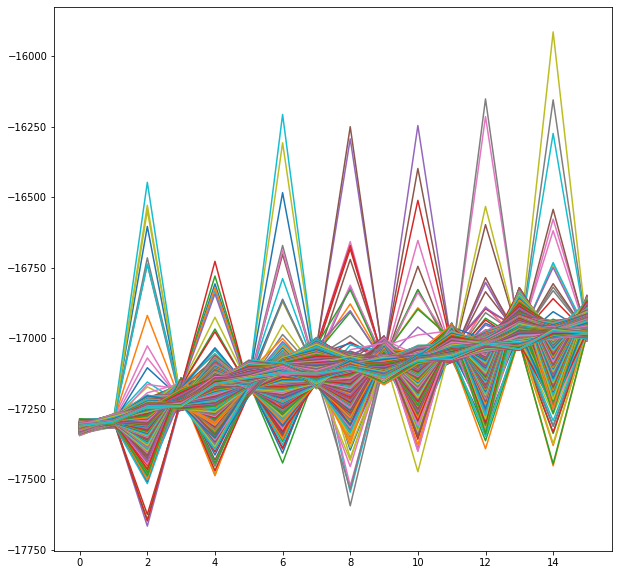

[[-17322.62675586 -17321.94536484 -17325.36448764 ... -17305.16611092
  -17309.89934498 -17309.32746323]
 [-17308.06202276 -17305.14177552 -17306.82091769 ... -17291.90332138
  -17295.22510261 -17295.94299673]
 [-17294.96958098 -17291.38011042 -17286.17233618 ... -17242.00359671
  -17242.96484476 -17242.52680767]
 ...
 [-17019.66327266 -17022.65652608 -17024.62769297 ... -17040.08066793
  -17038.60837662 -17037.78097323]
 [-17034.89722909 -17033.05990687 -17033.3275962  ... -16969.97039884
  -16969.20383394 -16972.74463372]
 [-16980.50762429 -16993.72174304 -17004.11295613 ... -16979.99658102
  -16982.004251   -16981.91907712]]


In [93]:
import matplotlib.pyplot as plt

# Data sequence
# pause pause signal pause ...

first_window = windows[12]

plt.figure(figsize=(10,10))
plt.plot(first_window)
plt.show()

print(first_window)

### Labeling data

New 


In [94]:
channels_list_df = channels_to_list_df(windows, 'jaw')

channel = channels_list_df[0]
channel.head()

,label,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,pause,-2553.890054,-2557.710711,-2570.961333,-2585.039358,-2573.200189,-2554.632283,-2559.548033,-2570.936997,-2576.010927,...,-2528.848934,-2529.408648,-2541.661519,-2553.379011,-2545.749865,-2528.702921,-2536.113049,-2558.124412,-2568.637302,-2559.621039
1,pause,-2535.577670,-2521.207620,-2535.930533,-2555.058153,-2549.485348,-2540.688103,-2537.062129,-2544.520927,-2560.229424,...,-2494.073656,-2490.703204,-2505.778981,-2518.810584,-2508.236855,-2495.521612,-2491.834800,-2499.281431,-2517.666820,-2524.857929
2,jaw,-2511.400457,-2507.896160,-2526.305885,-2534.044540,-2521.742999,-2501.374274,-2485.483262,-2494.840221,-2520.368049,...,-2290.009213,-2281.650005,-2293.537845,-2302.079568,-2299.633861,-2290.885287,-2278.827099,-2285.312482,-2305.048486,-2305.182331
3,pause,-2290.094387,-2286.371072,-2290.532424,-2306.277424,-2316.242767,-2302.262084,-2283.609004,-2288.792443,-2302.067400,...,-2595.673925,-2584.017271,-2585.258376,-2592.096622,-2598.934868,-2588.872182,-2571.350699,-2576.375958,-2591.634249,-2596.951533
4,jaw,-2594.213801,-2584.929848,-2581.486390,-2598.630675,-2614.217495,-2604.909207,-2594.761347,-2590.928523,-2594.469323,...,-2226.615512,-2212.902518,-2205.090857,-2219.801602,-2240.231165,-2231.579933,-2218.426652,-2217.258554,-2223.293731,-2236.666030


In [95]:
for channel_df in channels_list_df:
    channel_df['label'] = channel_df['label'].replace({'pause': 0, 'jaw': 1})

channel = channels_list_df[0]
channel.head()


,label,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,0,-2553.890054,-2557.710711,-2570.961333,-2585.039358,-2573.200189,-2554.632283,-2559.548033,-2570.936997,-2576.010927,...,-2528.848934,-2529.408648,-2541.661519,-2553.379011,-2545.749865,-2528.702921,-2536.113049,-2558.124412,-2568.637302,-2559.621039
1,0,-2535.577670,-2521.207620,-2535.930533,-2555.058153,-2549.485348,-2540.688103,-2537.062129,-2544.520927,-2560.229424,...,-2494.073656,-2490.703204,-2505.778981,-2518.810584,-2508.236855,-2495.521612,-2491.834800,-2499.281431,-2517.666820,-2524.857929
2,1,-2511.400457,-2507.896160,-2526.305885,-2534.044540,-2521.742999,-2501.374274,-2485.483262,-2494.840221,-2520.368049,...,-2290.009213,-2281.650005,-2293.537845,-2302.079568,-2299.633861,-2290.885287,-2278.827099,-2285.312482,-2305.048486,-2305.182331
3,0,-2290.094387,-2286.371072,-2290.532424,-2306.277424,-2316.242767,-2302.262084,-2283.609004,-2288.792443,-2302.067400,...,-2595.673925,-2584.017271,-2585.258376,-2592.096622,-2598.934868,-2588.872182,-2571.350699,-2576.375958,-2591.634249,-2596.951533
4,1,-2594.213801,-2584.929848,-2581.486390,-2598.630675,-2614.217495,-2604.909207,-2594.761347,-2590.928523,-2594.469323,...,-2226.615512,-2212.902518,-2205.090857,-2219.801602,-2240.231165,-2231.579933,-2218.426652,-2217.258554,-2223.293731,-2236.666030


**Filtering spurius data with z-score**

In [96]:
import scipy.stats as stats
for i in channel.keys()[1:]:
  name=str(i)+'_zscore'
  channel[name] = stats.zscore(channel[i])


**Defining X and y**

In [98]:
channel = channels_list_df[0]

Y = channel_df['label']
Y.head()

0    0
1    0
2    1
3    0
4    1
Name: label, dtype: int64

In [99]:
X = channel.drop(['label'], axis=1)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,1270_zscore,1271_zscore,1272_zscore,1273_zscore,1274_zscore,1275_zscore,1276_zscore,1277_zscore,1278_zscore,1279_zscore
0,-2553.890054,-2557.710711,-2570.961333,-2585.039358,-2573.200189,-2554.632283,-2559.548033,-2570.936997,-2576.010927,-2569.489041,...,0.382476,0.363766,0.341820,0.338992,0.364095,0.382526,0.351475,0.310145,0.307255,0.336856
1,-2535.577670,-2521.207620,-2535.930533,-2555.058153,-2549.485348,-2540.688103,-2537.062129,-2544.520927,-2560.229424,-2560.059076,...,0.437577,0.425246,0.398890,0.393968,0.423747,0.435399,0.422272,0.404209,0.388645,0.392367
2,-2511.400457,-2507.896160,-2526.305885,-2534.044540,-2521.742999,-2501.374274,-2485.483262,-2494.840221,-2520.368049,-2526.293717,...,0.760911,0.757309,0.736453,0.738649,0.755461,0.761476,0.762856,0.746251,0.728154,0.743154
3,-2290.094387,-2286.371072,-2290.532424,-2306.277424,-2316.242767,-2302.262084,-2283.609004,-2288.792443,-2302.067400,-2307.786218,...,0.276594,0.277025,0.272481,0.277417,0.279521,0.286649,0.295132,0.280969,0.270534,0.277245
4,-2594.213801,-2584.929848,-2581.486390,-2598.630675,-2614.217495,-2604.909207,-2594.761347,-2590.928523,-2594.469323,-2601.636096,...,0.861357,0.866508,0.877125,0.869501,0.849922,0.855976,0.859431,0.855040,0.858700,0.852564


In [100]:
cols = [range(0,1280)]
X.drop(X.columns[cols], axis=1, inplace=True)

**Training**

In [104]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

seed = 1234

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25, shuffle=True,random_state=seed)

X_train.head()

,0_zscore,1_zscore,2_zscore,3_zscore,4_zscore,5_zscore,6_zscore,7_zscore,8_zscore,9_zscore,...,1270_zscore,1271_zscore,1272_zscore,1273_zscore,1274_zscore,1275_zscore,1276_zscore,1277_zscore,1278_zscore,1279_zscore
14,-1.844403,-1.838523,-1.828448,-1.833613,-1.845762,-1.847068,-1.848556,-1.849560,-1.846525,-1.856029,...,-1.376728,-1.377646,-1.372274,-1.374815,-1.382747,-1.378695,-1.376014,-1.381373,-1.376729,-1.380357
2,0.320716,0.308545,0.271475,0.274508,0.310676,0.341862,0.350742,0.324914,0.293073,0.301398,...,0.760911,0.757309,0.736453,0.738649,0.755461,0.761476,0.762856,0.746251,0.728154,0.743154
10,0.261423,0.255306,0.255373,0.242536,0.229016,0.208567,0.197484,0.210753,0.216075,0.204074,...,-0.039665,-0.035324,-0.023165,-0.029530,-0.035476,-0.046330,-0.056638,-0.044365,-0.036781,-0.050323
7,0.851453,0.852593,0.863952,0.878162,0.869186,0.862450,0.883767,0.905178,0.911741,0.911505,...,1.041735,1.040454,1.042975,1.055058,1.049136,1.034138,1.043361,1.056122,1.052858,1.050593
1,0.279378,0.285821,0.255019,0.238608,0.263457,0.274946,0.262879,0.240227,0.225045,0.243776,...,0.437577,0.425246,0.398890,0.393968,0.423747,0.435399,0.422272,0.404209,0.388645,0.392367


In [105]:
import warnings
warnings.filterwarnings("ignore")

In [106]:
from sklearn.model_selection import train_test_split, GridSearchCV

lr_params = {'C': [9.08, 10.08, 100.08,200.08],
             'max_iter': [100,200, 500, 1000,50000,100000]}
lr_grid = GridSearchCV(estimator=LogisticRegression(random_state=seed),
                       param_grid=lr_params,
                       cv=3).fit(X_train, y_train)


lr_grid.best_estimator_.get_params()

{'C': 9.08,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1234,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [119]:
lr_opt = LogisticRegression(C=9.08, max_iter=100, penalty='l2', random_state=seed)
stats = lr_opt.fit(X_train, y_train)
score = lr_opt.score(X_test, y_test)

print("--stats--")
print(stats)
print("--score--")
print(score)

--stats--
LogisticRegression(C=9.08, random_state=1234)
--score--
0.75


**Cross Validation**

In [126]:
from sklearn.model_selection import KFold, cross_validate
for i, score in enumerate(cross_validate(lr_opt, X,Y, cv=5)["test_score"]):
    print(f"Accuracy for the fold no. {i} on the test set: {score}")

Accuracy for the fold no. 0 on the test set: 0.25
Accuracy for the fold no. 1 on the test set: 1.0
Accuracy for the fold no. 2 on the test set: 0.6666666666666666
Accuracy for the fold no. 3 on the test set: 1.0
Accuracy for the fold no. 4 on the test set: 0.3333333333333333


**Metrics**

In [127]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
import seaborn as sns

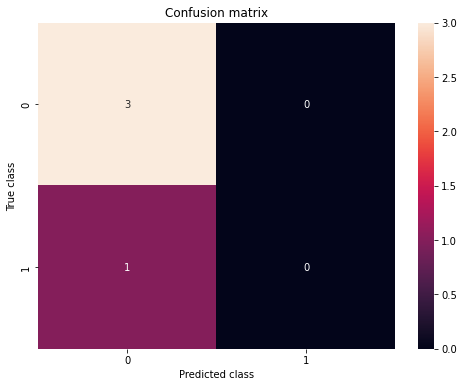

In [128]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_lr = lr_opt.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_lr, labels=[0, 1])
plt.figure(figsize=[8, 6])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class');

In [110]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



In [171]:
import numpy as np

for i in range(1,16):
  n_channel = i
  test_channel = channels_list_df[n_channel]
  test_no_label = test_channel.drop(['label'], axis=1)
#n_window = 4
#test_window = np.array(test_no_label.iloc[n_window]).reshape(1, 1280)
  test_window = test_no_label

  print(test_window.shape)
  print(i)
# other channel, window with label to test predict label 1 (jaw)
  lr_opt.predict(test_window)

  import pickle

  # Saving model
  filename = 'Jaw'+ str(i) + '_lregression.sav'
  pickle.dump(lr_opt, open(filename, 'wb'))

(16, 1280)
1
(16, 1280)
2
(16, 1280)
3
(16, 1280)
4
(16, 1280)
5
(16, 1280)
6
(16, 1280)
7
(16, 1280)
8
(16, 1280)
9
(16, 1280)
10
(16, 1280)
11
(16, 1280)
12
(16, 1280)
13
(16, 1280)
14
(16, 1280)
15
